<span style="color:#0b1f6a;font-weight:700;font-size:32px"> 
DS 5003 - XGBoost Model Run
</span> <br>

### Background
The dataset shows if the

In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import sys
import os
from datetime import datetime
import itertools
from itertools import product

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score,f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier
import shap

# NEW ➜ Yellowbrick visual diagnostics
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import inspect
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [2]:
os.getcwd()

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/DS5003/Code/Harold'

In [3]:
## set up absolute path to the Git Hub Main Child-Heath-in-Bangladesh-Capstone directory. 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
pd.set_option('display.max_columns', None)

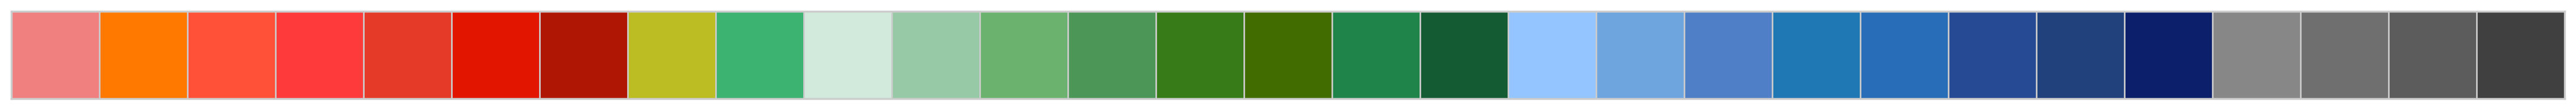

In [4]:
## colors - https://www.practicalpythonfordatascience.com/ap_seaborn_palette
color_scheme = ["#F08080", "#ff7800", "#ff5038", "#ff3a3a", "#e53a28", "#e11500", "#b01604", 
                "#BCBD22","#3CB371", "#d1eadc", "#98c9a7", "#6ab26e", "#4c9657", "#367b17", "#416d00", '#1e8449', '#145a32',
                "#95c5ff", "#6fa5df", "#4f80c7", "#1F77B4", "#276db7", '#274a94', '#21417c', '#0b1f6a',
                "#878787", "#6f6f6f", "#5d5c5c", "#404040"]

# Use list comprehension to select specific indices
selected_colors = [color_scheme[i] for i in [5, 20, 21]]
# Set your custom color palette
color_scheme_pal_three = sns.set_palette(sns.color_palette(selected_colors))

# Create a custom palette using HEX codes 
color_scheme_pal = sns.color_palette(color_scheme)
color_scheme_pal_two = [color_scheme_pal[0], color_scheme_pal[7]]
# color_scheme_pal_three = [color_scheme_pal[5], color_scheme_pal[20],color_scheme_pal[21]]

sns.palplot(sns.color_palette(color_scheme_pal))

### **Helper Functions**

In [5]:
def classif_metrics(cm_input, y_test, y_pred, y_proba):
    ### Extract TP, TN, FP, FN
    # TN, FP, FN, TP = cm.ravel()
    TP, FN, FP, TN = cm_input.ravel()
    
    print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
    print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
    print('\n')
    print(f'Accuracy: TP + TN / Total Population | % of Total True Values.   {round((TP+TN)/(TP+TN+FP+FN),3)}')
    precision_val = round(TP/(TP+FP),3); #print(precision_val)
    print(f'Precision: TP / (TP + FP) | % of Positive Class predicted correctly.   {precision_val}')
    npv_val = round(TN/(TN+FN),3); #print(precision_val)
    print(f'Neg. Predictive Value: TN / (TN + FN) | % of Negative Class predicted correctly.   {npv_val}')
    print('\n')
    recall_val = round(TP/(TP+FN),3); #print(recall_val)
    print(f'Sensitivity / Recall: TP / (TP + FN) | % of Actual Positive cases identified correctly.   {recall_val}')
    specificity_val = round(TN/(TN+FP),3);
    print(f'Specificity: TN / (TN + FP) | % Actual Negative cases identified correclty.   {specificity_val}')
    
    F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
    print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement.   {F1_val}')
    J_index = round(recall_val + specificity_val-1 ,3);  #print(J Index)
    print(f'J-Index Sensitivity + Specificity -1.   {J_index}')
    print('\n')
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("F1 Score", f1_score(y_test, y_pred))

<hr style="border:11px solid #0b1f6a">

### **Loading Data**

In [6]:
# ## Loading data
# path_one = project_root + '/Data/Modified_Tables/model_data_v4.csv.gz'
# vent_patient_df = pd.read_csv(path_one, compression='gzip')

In [7]:
## Loading data
path_two = project_root + '/Data/Modified_Tables/model_data_v5.csv.gz'
vent_patient_df = pd.read_csv(path_two, compression='gzip')

### **Review Data**

In [8]:
print(vent_patient_df.shape)
vent_patient_df.head(3)

(8392, 248)


,Vent_Duration_Cat,Vent_Dur_Min,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),LABEL_Non-invasive Ventilation,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sou

In [9]:
# print(vent_patient_df_v5.shape)
# vent_patient_df_v5.head(5)

----
#### **EDA**

In [10]:
data_types = pd.DataFrame(vent_patient_df.dtypes)
data_types.T

,Vent_Duration_Cat,Vent_Dur_Min,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),LABEL_Non-invasive Ventilation,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sou

In [11]:
vent_patient_df.isnull().sum()

Vent_Duration_Cat                    0
Vent_Dur_Min                         0
ICUSTAY_NUMBER                       0
Age_Admission                        0
50804_Calculated Total CO2           0
                                    ..
224642_Temperature Site_Oral         0
224642_Temperature Site_Rectal       0
224642_Temperature Site_Tympanic     0
224860_Skin Condition_Diaphoretic    0
224860_Skin Condition_Dry            0
Length: 248, dtype: int64

<hr style="border:11px solid #0b1f6a">

<span style="color:#0b1f6a;font-weight:700;font-size:26px"> 
ML Modeling
</span> <br>
The following section will model for the classification of <br>
 1. XGBoost <br>


----
## **Setting up data**

### **Encode Y value into new Feature**

In [12]:
# Initialize the encoder
le = LabelEncoder()

# Fit and transform the column
vent_patient_df['Vent_Duration_Cat_encoded'] = le.fit_transform(vent_patient_df['Vent_Duration_Cat'])

# Optionally: See the mapping of original labels to integers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Mod_Under_Day': 0, 'Sig_Over_Day': 1}


In [13]:
vent_patient_df['Vent_Duration_Cat'].value_counts()

Vent_Duration_Cat
Sig_Over_Day     4205
Mod_Under_Day    4187
Name: count, dtype: int64

In [14]:
print(vent_patient_df.shape)
vent_patient_df.head(7)

(8392, 249)


,Vent_Duration_Cat,Vent_Dur_Min,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),LABEL_Non-invasive Ventilation,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sou

----
### **Optional Outlier Removal**

In [15]:
vent_patient_df['Vent_Dur_Min'].describe(percentiles=[.01, .025, .05, .10, .25, .5, .75, .90, .95, .975, .99])

count      8392.000000
mean       4203.517517
std        7257.412939
min           3.000000
1%           74.000000
2.5%        126.000000
5%          176.000000
10%         240.000000
25%         584.500000
50%        1450.000000
75%        4676.250000
90%       11323.600000
95%       16997.250000
97.5%     22925.850000
99%       33179.140000
max      135267.000000
Name: Vent_Dur_Min, dtype: float64

In [16]:
## Removing Outliers
vent_patient_df = vent_patient_df.query(' Vent_Dur_Min > 90 & Vent_Dur_Min < 32000 ')
vent_patient_df.shape

(8182, 249)

-----
#### **Invasive Only: Review of Non-Invasive Records / Create New DF**

In [17]:
### How many tags are Non Invasive - not a large amount. 
vent_patient_df['LABEL_Non-invasive Ventilation'].value_counts()

LABEL_Non-invasive Ventilation
0.0    7769
1.0     413
Name: count, dtype: int64

In [18]:
### Remove Non Invasive Population
vent_patient_invasive = vent_patient_df.query(' `LABEL_Non-invasive Ventilation` == 0')
print(vent_patient_invasive.shape)
vent_patient_invasive.head(2)

(7769, 249)


,Vent_Duration_Cat,Vent_Dur_Min,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),LABEL_Non-invasive Ventilation,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sou

In [19]:
vent_patient_invasive['Vent_Dur_Min'].describe(percentiles=[.01, .025, .05, .10, .25, .5, .75, .90, .95, .975, .99])

count     7769.000000
mean      3856.066675
std       5316.072646
min         91.000000
1%         128.000000
2.5%       162.000000
5%         199.000000
10%        257.000000
25%        618.000000
50%       1477.000000
75%       4821.000000
90%      11070.400000
95%      15753.000000
97.5%    20004.200000
99%      25145.840000
max      31967.000000
Name: Vent_Dur_Min, dtype: float64

In [20]:
### Dropping Col. because the Non-Inv. were removed. 
vent_patient_invasive = vent_patient_invasive.drop(columns=['LABEL_Non-invasive Ventilation'])

In [21]:
print(vent_patient_invasive.shape)
vent_patient_invasive.head(1)

(7769, 248)


,Vent_Duration_Cat,Vent_Dur_Min,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sounds_Insp Wheeze,223986_RUL Lung

---
#### **Pair Down Data - Remove extra Ys**

In [22]:
### Remove old Y values
vent_patient_df = vent_patient_df.iloc[:,2:]
vent_patient_invasive = vent_patient_invasive.iloc[:,2:]

----
### **Set Model Variables: X and Y for Training / Testing**

#### **Both Inv and Non-Invasive Population Only**

In [23]:
### All Data Set up X / Y variables:
target_col = 'Vent_Duration_Cat_encoded'        # outcome label
y_val = vent_patient_df[target_col]
X_val = vent_patient_df.iloc[:,:-1]

#### **Invasive Population Only**

In [24]:
# ### Invasive Only:: Data Set up X / Y variables:
# target_col = 'Vent_Duration_Cat_encoded'        # outcome label
# y_val = vent_patient_invasive[target_col]
# X_val = vent_patient_invasive.iloc[:,:-1]

In [25]:
print(y_val.shape)
print(X_val.shape)

(8182,)
(8182, 246)


In [26]:
X_val.head(1)

,ICUSTAY_NUMBER,Age_Admission,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223835_Inspired O2 Fraction,223873_Paw High,223876_Apnea Interval,224168_Parameters Checked,224641_Alarms On,224687_Minute Volume,224697_Mean Airway Pressure,226253_SpO2 Desat Limit,226512_Admission Weight (Kg),LABEL_Non-invasive Ventilation,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,GENDER_M,Resp_Diag_Label_Resp_Related,220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),220048_Heart Rhythm_3rd AV (Complete Heart Block),220048_Heart Rhythm_A Flut (Atrial Flutter),220048_Heart Rhythm_A Paced,220048_Heart Rhythm_AF (Atrial Fibrillation),220048_Heart Rhythm_AV Paced,220048_Heart Rhythm_Asystole,220048_Heart Rhythm_Idioventricular,220048_Heart Rhythm_JR (Junctional Rhythm),220048_Heart Rhythm_JT (Junctional Tachycardia),220048_Heart Rhythm_LBBB (Left Bundle Branch Block),220048_Heart Rhythm_MAT (Multifocal atrial tachycardia),220048_Heart Rhythm_PAT (Paroxysmal Atrial Tachycardia),220048_Heart Rhythm_RBBB (Right Bundle Branch Block),220048_Heart Rhythm_SA (Sinus Arrhythmia),220048_Heart Rhythm_SB (Sinus Bradycardia),220048_Heart Rhythm_SR (Sinus Rhythm),220048_Heart Rhythm_ST (Sinus Tachycardia),220048_Heart Rhythm_SVT (Supra Ventricular Tachycardia),220048_Heart Rhythm_V Paced,220048_Heart Rhythm_VF (Ventricular Fibrillation),220048_Heart Rhythm_VT (Ventricular Tachycardia),220048_Heart Rhythm_WAP (Wandering atrial pacemaker),223781_Pain Present_Yes,223795_Pain Assessment Method_FLACC,223795_Pain Assessment Method_Grimace Scale,223795_Pain Assessment Method_Non-verbal Cues,223795_Pain Assessment Method_Not applicable,223795_Pain Assessment Method_PAINAD,223795_Pain Assessment Method_Patient Verbalized,223795_Pain Assessment Method_Wong-Baker Scale,223849_Ventilator Mode_CMV,223849_Ventilator Mode_CMV/ASSIST,223849_Ventilator Mode_CMV/ASSIST/AutoFlow,223849_Ventilator Mode_CMV/AutoFlow,223849_Ventilator Mode_CPAP,223849_Ventilator Mode_CPAP/PPS,223849_Ventilator Mode_CPAP/PSV,223849_Ventilator Mode_CPAP/PSV+Apn TCPL,223849_Ventilator Mode_CPAP/PSV+ApnPres,223849_Ventilator Mode_CPAP/PSV+ApnVol,223849_Ventilator Mode_MMV/PSV,223849_Ventilator Mode_MMV/PSV/AutoFlow,223849_Ventilator Mode_PCV+,223849_Ventilator Mode_PCV+/PSV,223849_Ventilator Mode_PCV+Assist,223849_Ventilator Mode_PRES/AC,223849_Ventilator Mode_PRVC/AC,223849_Ventilator Mode_PRVC/SIMV,223849_Ventilator Mode_PSV/SBT,223849_Ventilator Mode_SIMV,223849_Ventilator Mode_SIMV/AutoFlow,223849_Ventilator Mode_SIMV/PRES,223849_Ventilator Mode_SIMV/PSV,223849_Ventilator Mode_SIMV/PSV/AutoFlow,223849_Ventilator Mode_SIMV/VOL,223849_Ventilator Mode_Standby,223849_Ventilator Mode_VOL/AC,223900_GCS - Verbal Response_Inappropriate Words,223900_GCS - Verbal Response_Incomprehensible sounds,223900_GCS - Verbal Response_No Response,223900_GCS - Verbal Response_No Response-ETT,223900_GCS - Verbal Response_Oriented,223901_GCS - Motor Response_Abnormal extension,223901_GCS - Motor Response_Flex-withdraws,223901_GCS - Motor Response_Localizes Pain,223901_GCS - Motor Response_No response,223901_GCS - Motor Response_Obeys Commands,223985_Respiratory Pattern_Cheyne-Stokes,223985_Respiratory Pattern_Discoordinate,223985_Respiratory Pattern_Irregular,223985_Respiratory Pattern_Kussmaul,223985_Respiratory Pattern_Regular,223985_Respiratory Pattern_Tachypneic,223986_RUL Lung Sounds_Bronchial,223986_RUL Lung Sounds_Clear,223986_RUL Lung Sounds_Crackles,223986_RUL Lung Sounds_Diminished,223986_RUL Lung Sounds_Exp Wheeze,223986_RUL Lung Sounds_Ins/Exp Wheeze,223986_RUL Lung Sounds_Insp Wheeze,223986_RUL Lung

In [27]:
## Test / Train Split
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.20, stratify=y_val, random_state=37)

### Apply partial undersampling to training set
# rus = RandomUnderSampler(sampling_strategy=0.2, random_state=42)  # e.g., reduce majority class
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [28]:
print(f' X Training Shape: {X_train.shape} ')
# print(f' X Undersampled Training Shape {X_train_resampled.shape} ')
print(f' X Test Shape {X_test.shape} ')
print('\n')
print(f' Y Training Values {y_train.value_counts()} ')
print('\n')
# print(f'Adjusted Resampled Y Training Values {y_train_resampled.value_counts()} ')

 X Training Shape: (6545, 246) 
 X Test Shape (1637, 246) 


 Y Training Values Vent_Duration_Cat_encoded
1    3288
0    3257
Name: count, dtype: int64 




<hr style="border:16px solid #0b1f6a">

# **XGBoost**

<hr style="border:9px solid #0b1f6a">

------

## **Grid Search / Multiple Parameters**

In [29]:
### Determine Imbalance Param
# Count imbalance
# neg = np.sum(y_train == 0)
# pos = np.sum(y_train == 1)

# scale_pos_weight = neg / pos
# print("scale_pos_weight:", scale_pos_weight)

In [31]:
### Define parameter values
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [10,13,16],
    'learning_rate': [.1, 0.01],
    # 'scale_pos_weight': [1, 5, 10],
    'gamma': [0.0, 0.5],
    # 'reg_alpha': [0, 0.5, 1.0],   # L1 regularization
    'reg_lambda': [0, 1.0, 5.0]  # L2 regularization
}


# Generate all combinations
param_combos = list(product(
    param_grid['n_estimators'], ### # of Trees
    param_grid['max_depth'],   ### Max depth per tree
    param_grid['learning_rate'],   ### Learning Rate 
    # param_grid['scale_pos_weight'],   ### Class imbalance
    param_grid['gamma'],
    # param_grid['reg_alpha']
    param_grid['reg_lambda']
))

results = []

# Manual loop
for n, depth, lr, gam, reg_lambda in param_combos:  ### spw  reg_lambda reg_alpha
    xgb_tuning = XGBClassifier(
        n_estimators=n,
        max_depth=depth,
        learning_rate=lr,
        # scale_pos_weight=spw,
        gamma=gam,
        # reg_alpha=reg_alpha,     # L1 regularization term
        reg_lambda=reg_lambda,      # L2 regularization term
        booster='gbtree', # or 'dart' if needed
        eval_metric='auc',
        random_state=37,
        n_jobs=-1
    )
    
    xgb_tuning.fit(X_train, y_train)
    y_pred = xgb_tuning.predict(X_test)
    y_proba = xgb_tuning.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    youdens_J = recall + specificity - 1

    results.append({
        'n_estimators': n,
        'max_depth': depth,
        'learning_rate': lr,
        # 'scale_pos_weight': spw,
        'gamma': gam,
        # 'L1 alpha': reg_alpha,
        'L2 ridge reg': reg_lambda,
        'AUC': auc,
        'F1': f1,
        'Accuracy': acc,
        'Recall': recall,
        'Precision': precision,
        'Specificity': specificity,
        "Youden's J": youdens_J
    })

# Save results to DataFrame
xgb_tuning_results_df = pd.DataFrame(results).sort_values(['Accuracy', 'AUC'], ascending=False)

In [32]:
xgb_tuning_results_df = xgb_tuning_results_df.sort_values(['Recall', 'AUC','Accuracy'], ascending=False)
xgb_tuning_results_df[0:15]

,n_estimators,max_depth,learning_rate,gamma,L2 ridge reg,AUC,F1,Accuracy,Recall,Precision,Specificity,Youden's J
80,1200,10,0.01,0.0,5.0,0.822126,0.764571,0.748627,0.811893,0.722462,0.684663,0.496556
44,1000,10,0.01,0.0,5.0,0.823347,0.764200,0.749237,0.808252,0.724701,0.689571,0.497823
20,800,13,0.01,0.0,5.0,0.820837,0.757248,0.739475,0.808252,0.712299,0.669939,0.478191
56,1000,13,0.01,0.0,5.0,0.820804,0.758110,0.740696,0.808252,0.713826,0.672393,0.480645
62,1000,16,0.10,0.0,5.0,0.817666,0.763929,0.749237,0.807039,0.725191,0.690798,0.497836
18,800,13,0.01,0.0,0.0,0.816200,0.755253,0.737035,0.807039,0.709712,0.666258,0.473297
4,800,10,0.10,0.5,1.0,0.816765,0.759725,0.743746,0.805825,0.718615,0.680982,0.486807
40,1000,10,0.10,0.5,1.0,0.816765,0.759725,0.743746,0.805825,0.718615,0.680982,0.486807
76,1200,10,0.10,0.5,1.0,0.816765,0.759725,0.743746,0.805825,0.718615,0.680982,0.486807
11,800,10,0.01,0.5,5.0,0.824553,0.760321,0.744966,0.804612,0.720652,0.684663,0.489274


In [33]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'xgb_tuning_results_df'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
xgb_tuning_results_df.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to xgb_tuning_results_df.csv


<hr style="border:9px solid #0b1f6a">

## **Single Param**

In [35]:
classes = np.sort(y_train.unique())  #
classes

array([0, 1])

In [38]:
### Model 
n = 1000
depth = 10
lr = .01
# spw = 5
gam = 0
reg_alpha = .5
reg_lambda = 5  # L2 regularization

xgb_mod_ventilation = XGBClassifier(
        # objective='binary:logistic',
        n_estimators=n,
        max_depth=depth,
        learning_rate=lr,
        # scale_pos_weight=spw,
        gamma=gam,
        # reg_alpha=reg_alpha,     # L1 regularization term
        reg_lambda=reg_lambda,      # L2 regularization term
        eval_metric='auc',
        random_state=37,
        n_jobs=-1
    )

xgb_mod_ventilation.fit(X_train, y_train)
y_pred = xgb_mod_ventilation.predict(X_test)
y_proba = xgb_mod_ventilation.predict_proba(X_test)[:, 1]

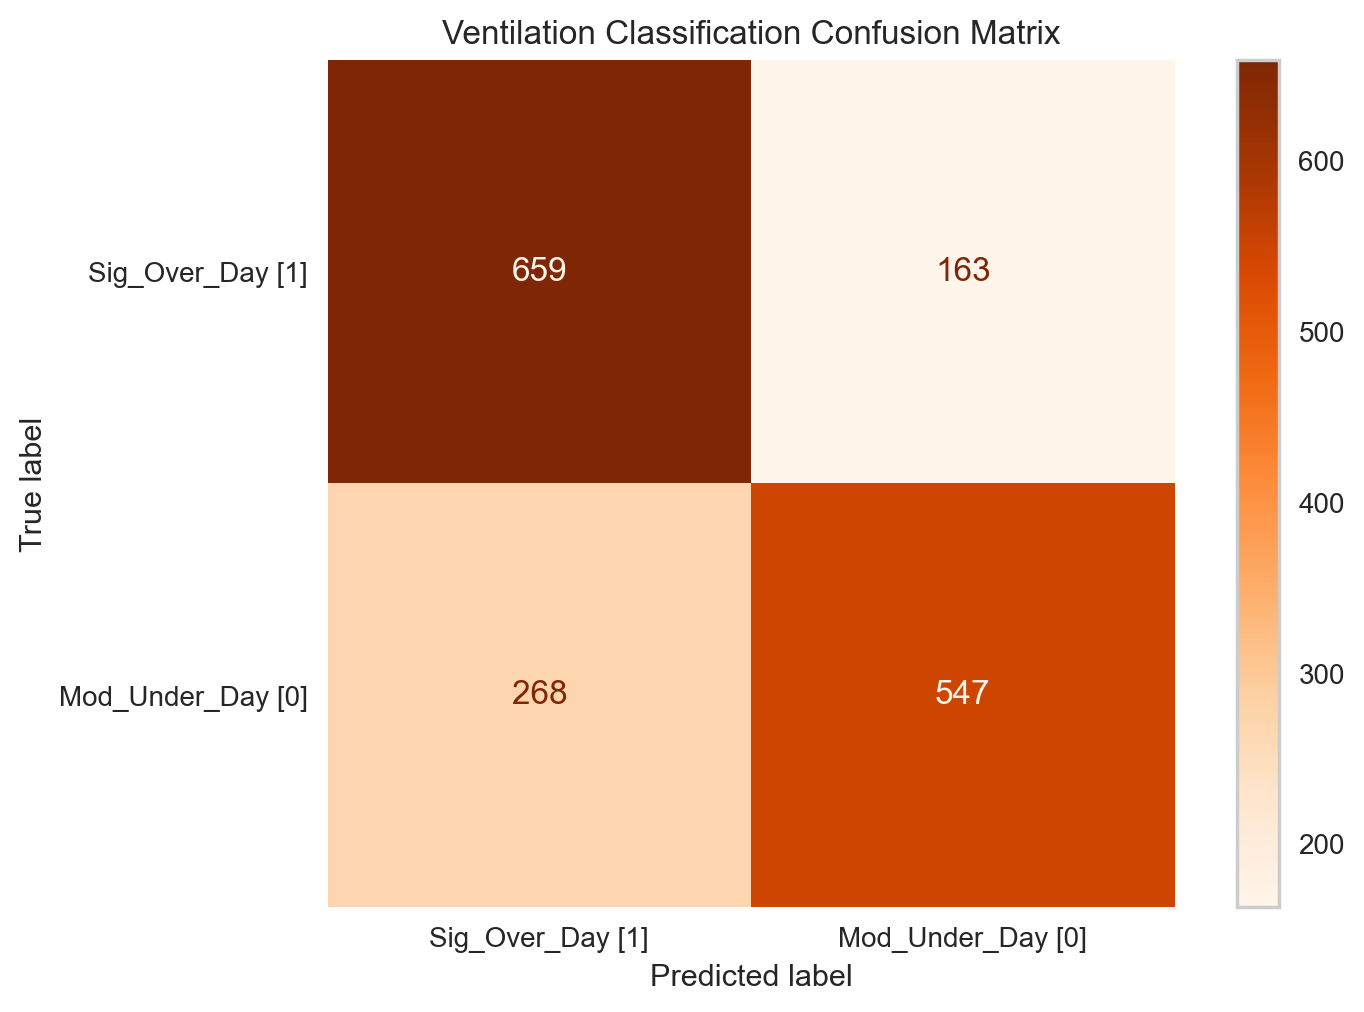

In [39]:
# Generate confusion matrix
labels_rev = xgb_mod_ventilation.classes_[::-1]   ### Reverse Labels
cm_xgb = confusion_matrix(y_test, y_pred, labels=labels_rev) 

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels = ['Sig_Over_Day [1]', 'Mod_Under_Day [0]'])
TP, FN, FP, TN = cm_xgb.ravel()

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Oranges, ax=ax, colorbar=True)  ##coolwarm bwr seismic PiYG RdYlBu Reds Spectral
ax.grid(False)           # <- kill the grid
for spine in ax.spines.values():
    spine.set_visible(False)   # optional: hide the outer box
plt.title('Ventilation Classification Confusion Matrix')
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') # Save to file (adjust path/format as needed)
plt.show()

In [40]:
TP, FN, FP, TN = cm_xgb.ravel()
print(TP, FN, FP, TN)
633 +155+ 225+ 547

659 163 268 547


1560

In [41]:
## Print classification metrics:
classif_metrics(cm_xgb, y_test, y_pred, y_proba)

True Positives (TP): 659  False Negatives (FN): 163
False Positives (FP): 268 True Negatives (TN): 547


Accuracy: TP + TN / Total Population | % of Total True Values.   0.737
Precision: TP / (TP + FP) | % of Positive Class predicted correctly.   0.711
Neg. Predictive Value: TN / (TN + FN) | % of Negative Class predicted correctly.   0.77


Sensitivity / Recall: TP / (TP + FN) | % of Actual Positive cases identified correctly.   0.802
Specificity: TN / (TN + FP) | % Actual Negative cases identified correclty.   0.671
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement.   0.754
J-Index Sensitivity + Specificity -1.   0.473


ROC-AUC: 0.825257862761781
Accuracy 0.7367135003054368
F1 Score 0.7535734705546026


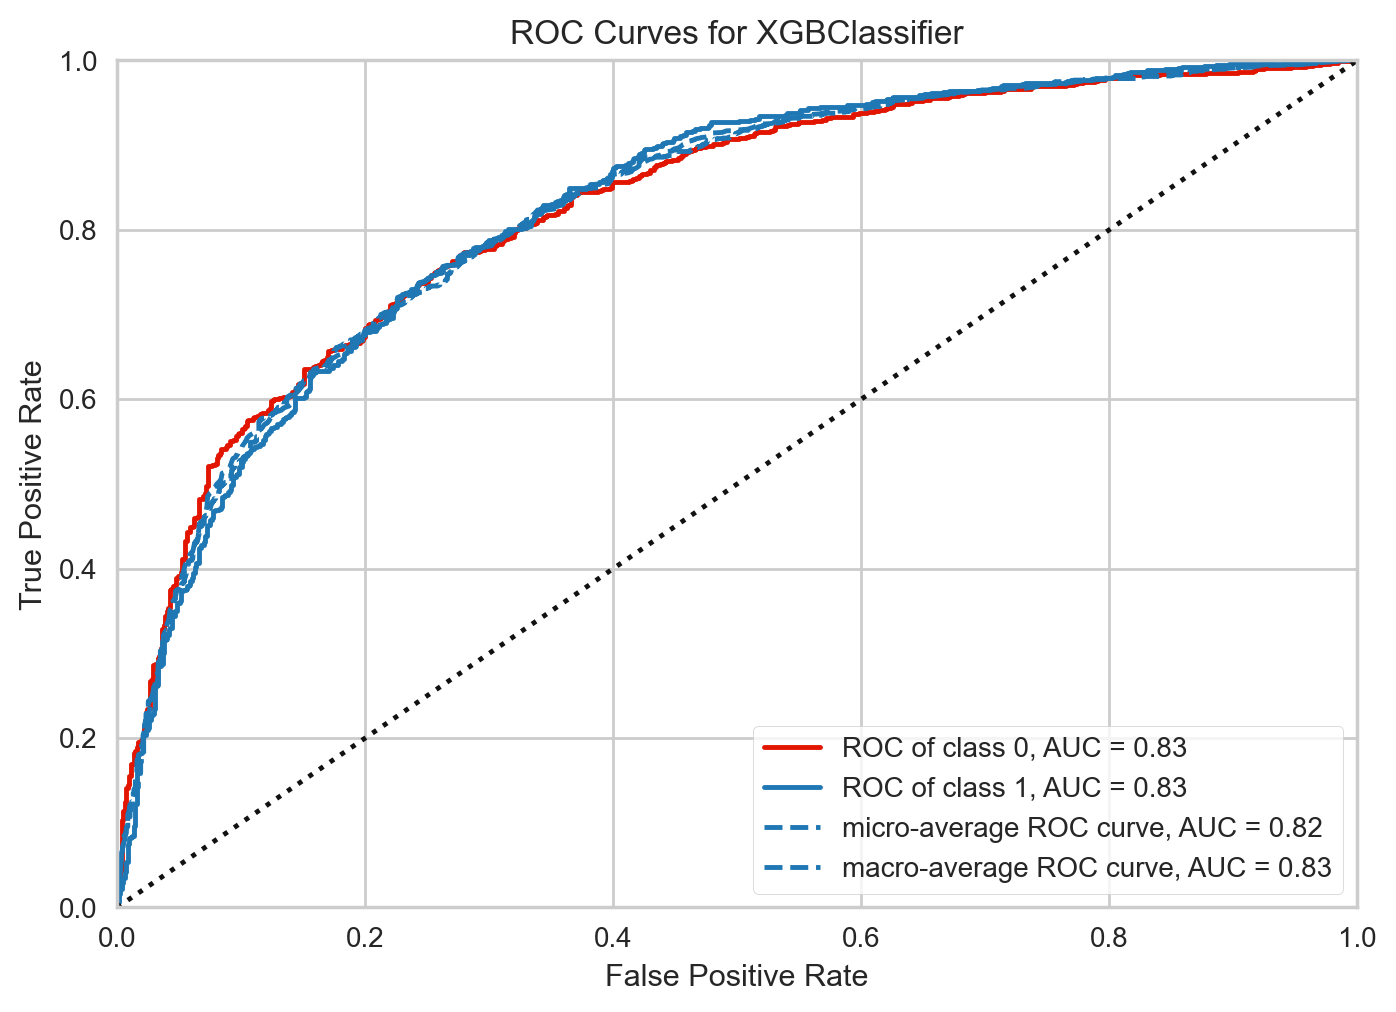

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [42]:
visualizer = ROCAUC(xgb_mod_ventilation, classes=classes)

# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()         

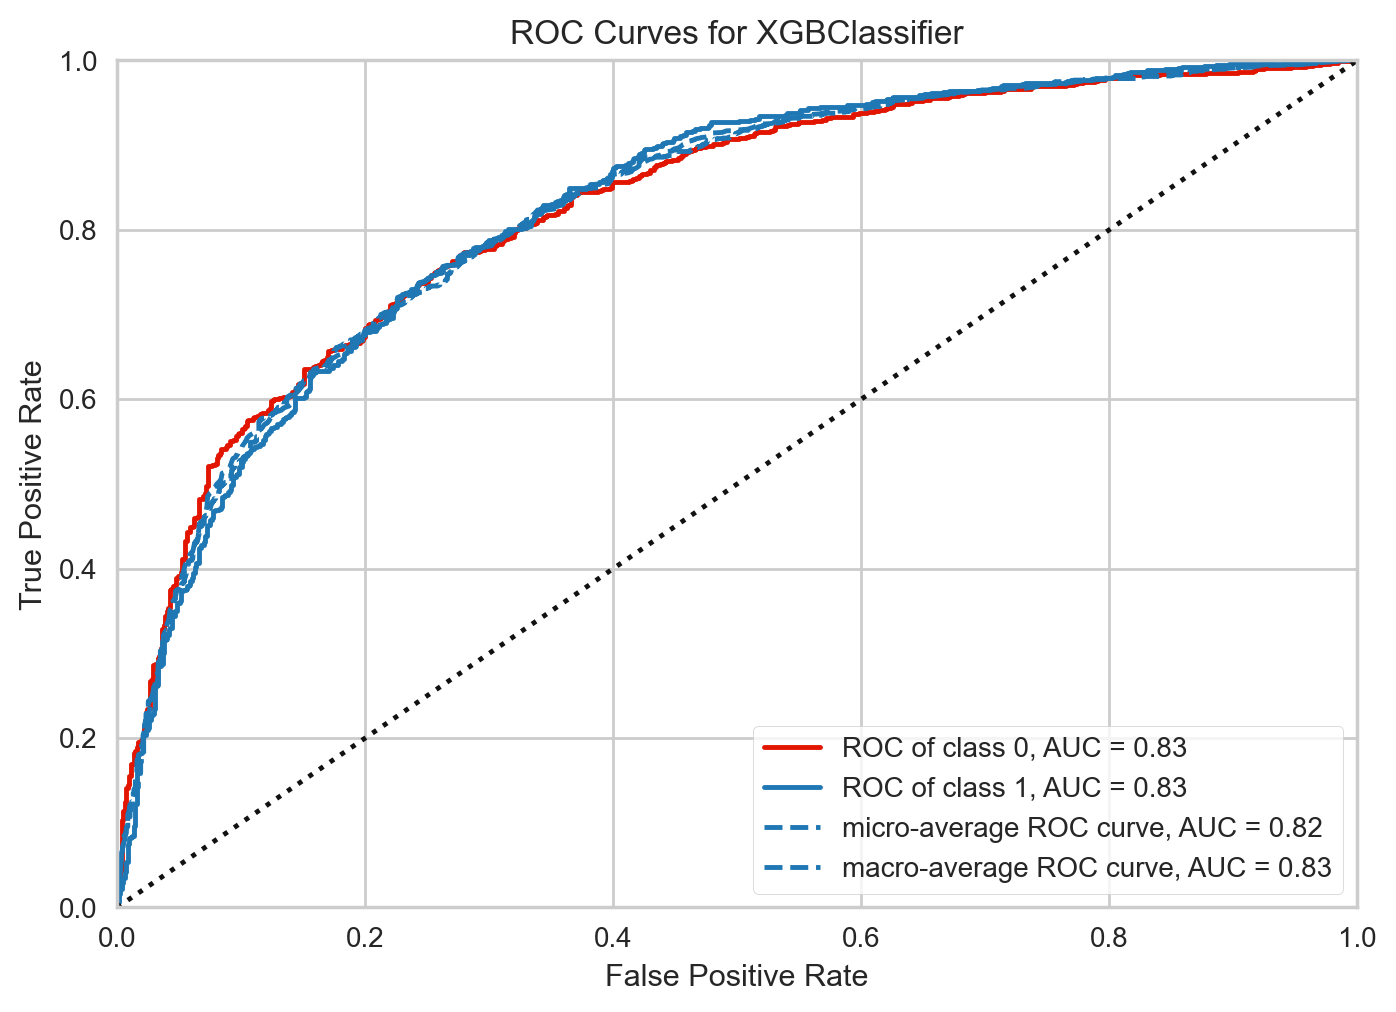

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [43]:

# Initialize the visualizer
visualizer = ROCAUC(xgb_mod_ventilation, classes=classes)

# Fit and score the model
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

# # Manually set title and legend if needed
# visualizer.ax_.set_title("ROC Curve - XGBoost Ventilation Model", fontsize=14, weight='bold')
# visualizer.ax_.legend(loc="lower right", fontsize=10)

# Save after full rendering
visualizer.finalize()  # Ensure full rendering before saving
plt.savefig("visualizer.png", dpi=300, bbox_inches="tight")  # Save image
visualizer.show()

#### **Review Thresholds**

In [44]:
# Define thresholds to evaluate
threshold_options = np.arange(0.3, 0.7, 0.025)
threshold_options

array([0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475, 0.5  ,
       0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675])

In [45]:
xgb_mod_ventilation.classes_[::-1] 

array([1, 0])

In [46]:
auc_val = roc_auc_score(y_test, y_proba)
auc_val

0.825257862761781

In [47]:
# Store performance results
performance_results = []

for t in threshold_options:
    y_pred = (y_proba >= t).astype(int)
    labels_rev = xgb_mod_ventilation.classes_[::-1]   ### Reverse Labels
    # ### Confusion matrix: [ [TN, FP], [FN, TP] ]
    cm_thresh_xgb = confusion_matrix(y_test, y_pred, labels=labels_rev) 
    TP, FN, FP, TN = cm_thresh_xgb.ravel()    ### cm_xgb.ravel()
    print(t, TP)
    
    auc_val = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    performance_results.append({
        'Threshold': t,
        'ROC-AUC': auc_val,
        'Recall % Trues Ident.': recall,
        'Specificity': specificity,
        'Precision % Pred.': precision,
        'Accuracy': accuracy,
         'F1': f1, 
        'TP': TP,
        'FN': FN,
        'FP': FP,
        'TN': TN 
    })

# Convert to DataFrame
threshold_performance_df = pd.DataFrame(performance_results)


0.3 762
0.325 751
0.35000000000000003 740
0.37500000000000006 723
0.4000000000000001 712
0.4250000000000001 698
0.4500000000000001 691
0.47500000000000014 676
0.5000000000000002 659
0.5250000000000001 650
0.5500000000000003 634
0.5750000000000002 617
0.6000000000000003 603
0.6250000000000002 575
0.6500000000000004 556
0.6750000000000003 530


In [48]:
### Checking Recall for the final Threshold.......
print(TP, FN, FP, TN)
print(TP + FN+ FP+ TN)
print(f' recall =  {TP / (TP + FN)} ')
print(f' specificity = {TN / (TN + FP)} ')

530 292 147 668
1637
 recall =  0.6447688564476886 
 specificity = 0.8196319018404908 


In [49]:
threshold_performance_df

,Threshold,ROC-AUC,Recall % Trues Ident.,Specificity,Precision % Pred.,Accuracy,F1,TP,FN,FP,TN
0,0.300,0.825258,0.927007,0.519018,0.660312,0.723885,0.771255,762,60,392,423
1,0.325,0.825258,0.913625,0.541104,0.667556,0.728161,0.771443,751,71,374,441
2,0.350,0.825258,0.900243,0.560736,0.673953,0.731216,0.770833,740,82,358,457
3,0.375,0.825258,0.879562,0.585276,0.681433,0.733048,0.767924,723,99,338,477
4,0.400,0.825258,0.866180,0.602454,0.687259,0.734881,0.766416,712,110,324,491
5,0.425,0.825258,0.849148,0.618405,0.691774,0.734270,0.762425,698,124,311,504
6,0.450,0.825258,0.840633,0.638037,0.700811,0.739768,0.764381,691,131,295,520
7,0.475,0.825258,0.822384,0.658896,0.708595,0.740990,0.761261,676,146,278,537
8,0.500,0.825258,0.801703,0.671166,0.710895,0.736714,0.753573,659,163,268,547
9,0.525,0.825258,0.790754,0.694479,0.723026,0.742822,0.755375,650,172,249,566


In [50]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'xgb_threshold_iter_results'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
threshold_performance_df.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to xgb_threshold_iter_results.csv


#### **Plot**

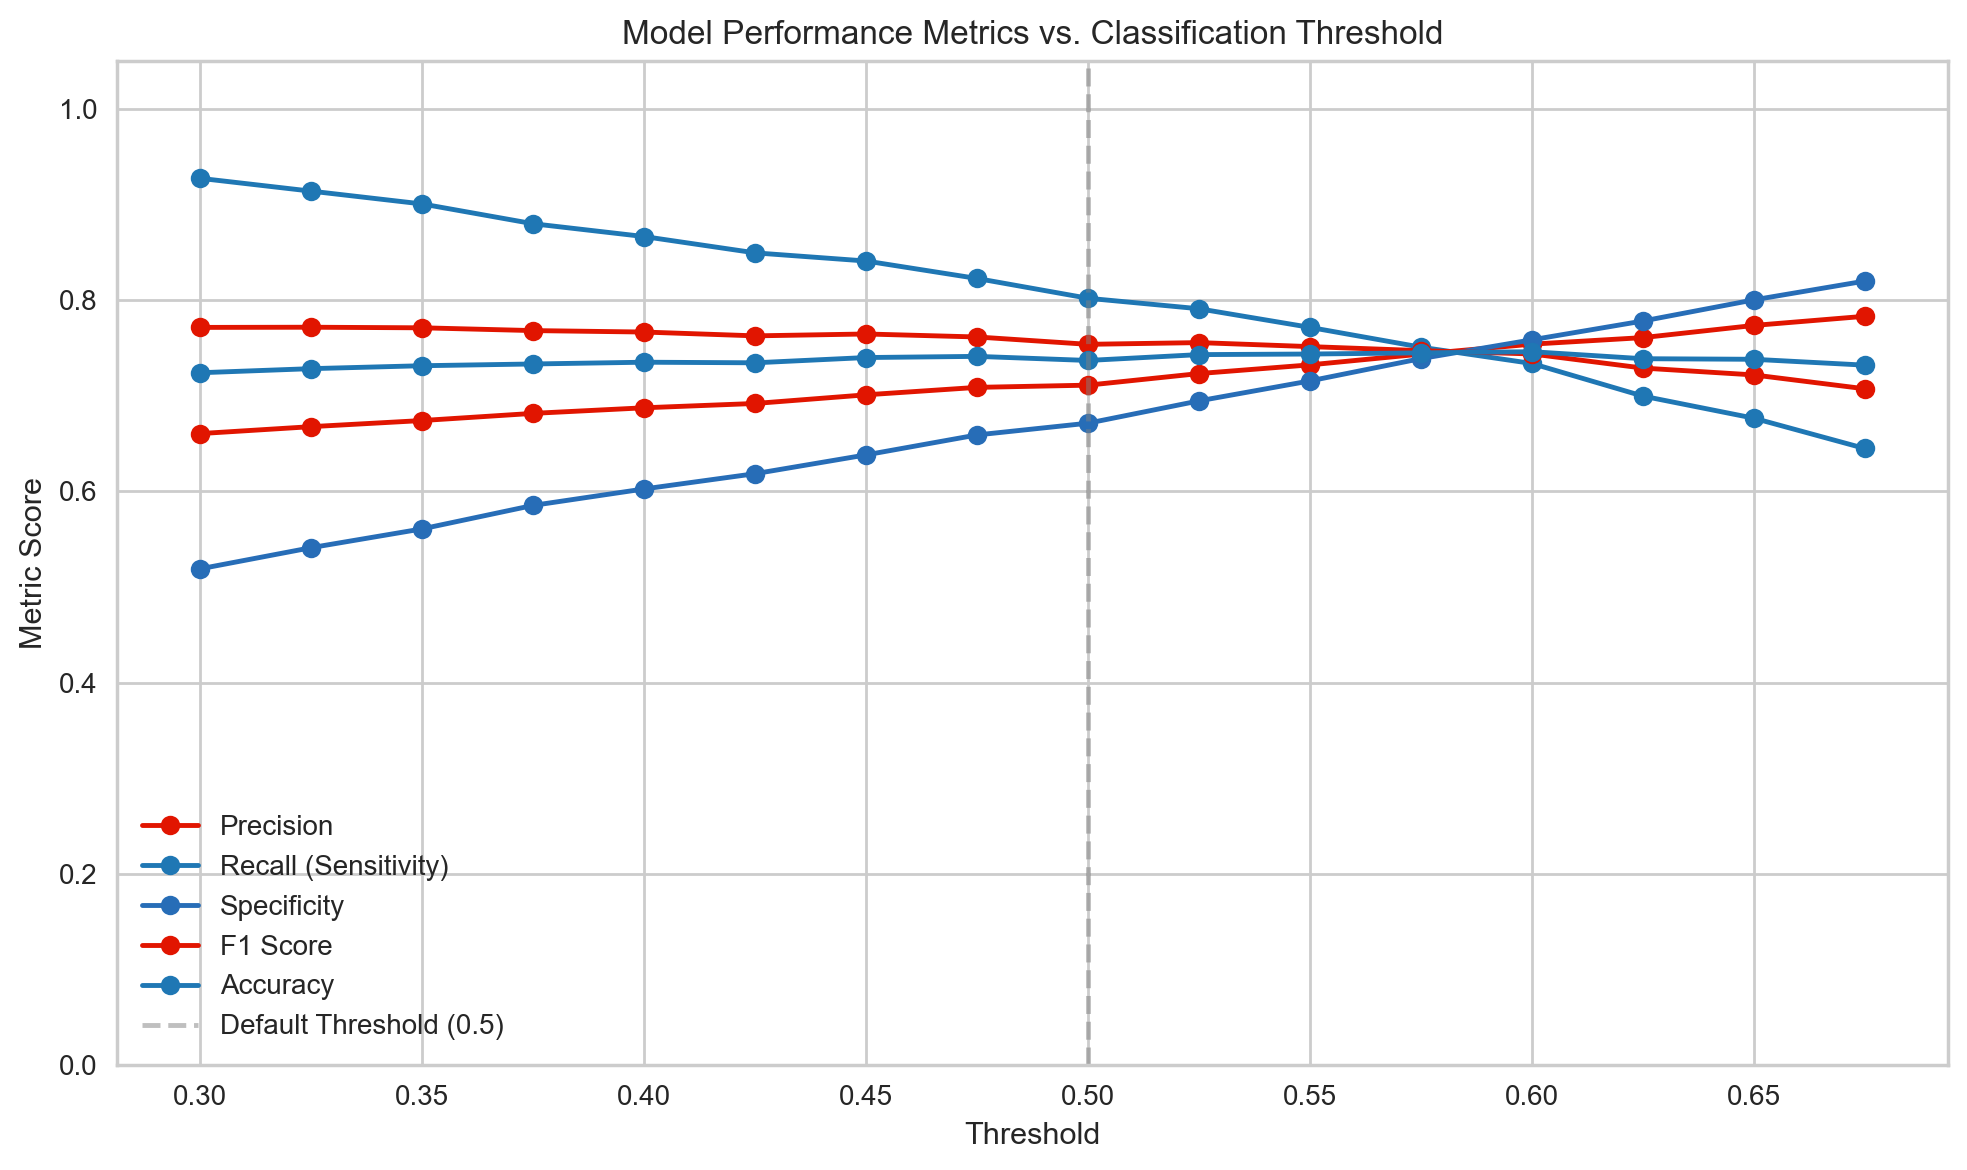

In [51]:

plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(threshold_performance_df['Threshold'], threshold_performance_df['Precision % Pred.'], label='Precision', marker='o')
plt.plot(threshold_performance_df['Threshold'], threshold_performance_df['Recall % Trues Ident.'], label='Recall (Sensitivity)', marker='o')
plt.plot(threshold_performance_df['Threshold'], threshold_performance_df['Specificity'], label='Specificity', marker='o')
plt.plot(threshold_performance_df['Threshold'], threshold_performance_df['F1'], label='F1 Score', marker='o')
plt.plot(threshold_performance_df['Threshold'], threshold_performance_df['Accuracy'], label='Accuracy', marker='o')

# Reference line at default threshold 0.5
plt.axvline(0.5, linestyle='--', color='gray', alpha=0.5, label='Default Threshold (0.5)')

# Style
plt.title("Model Performance Metrics vs. Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.ylim(0, 1.05)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


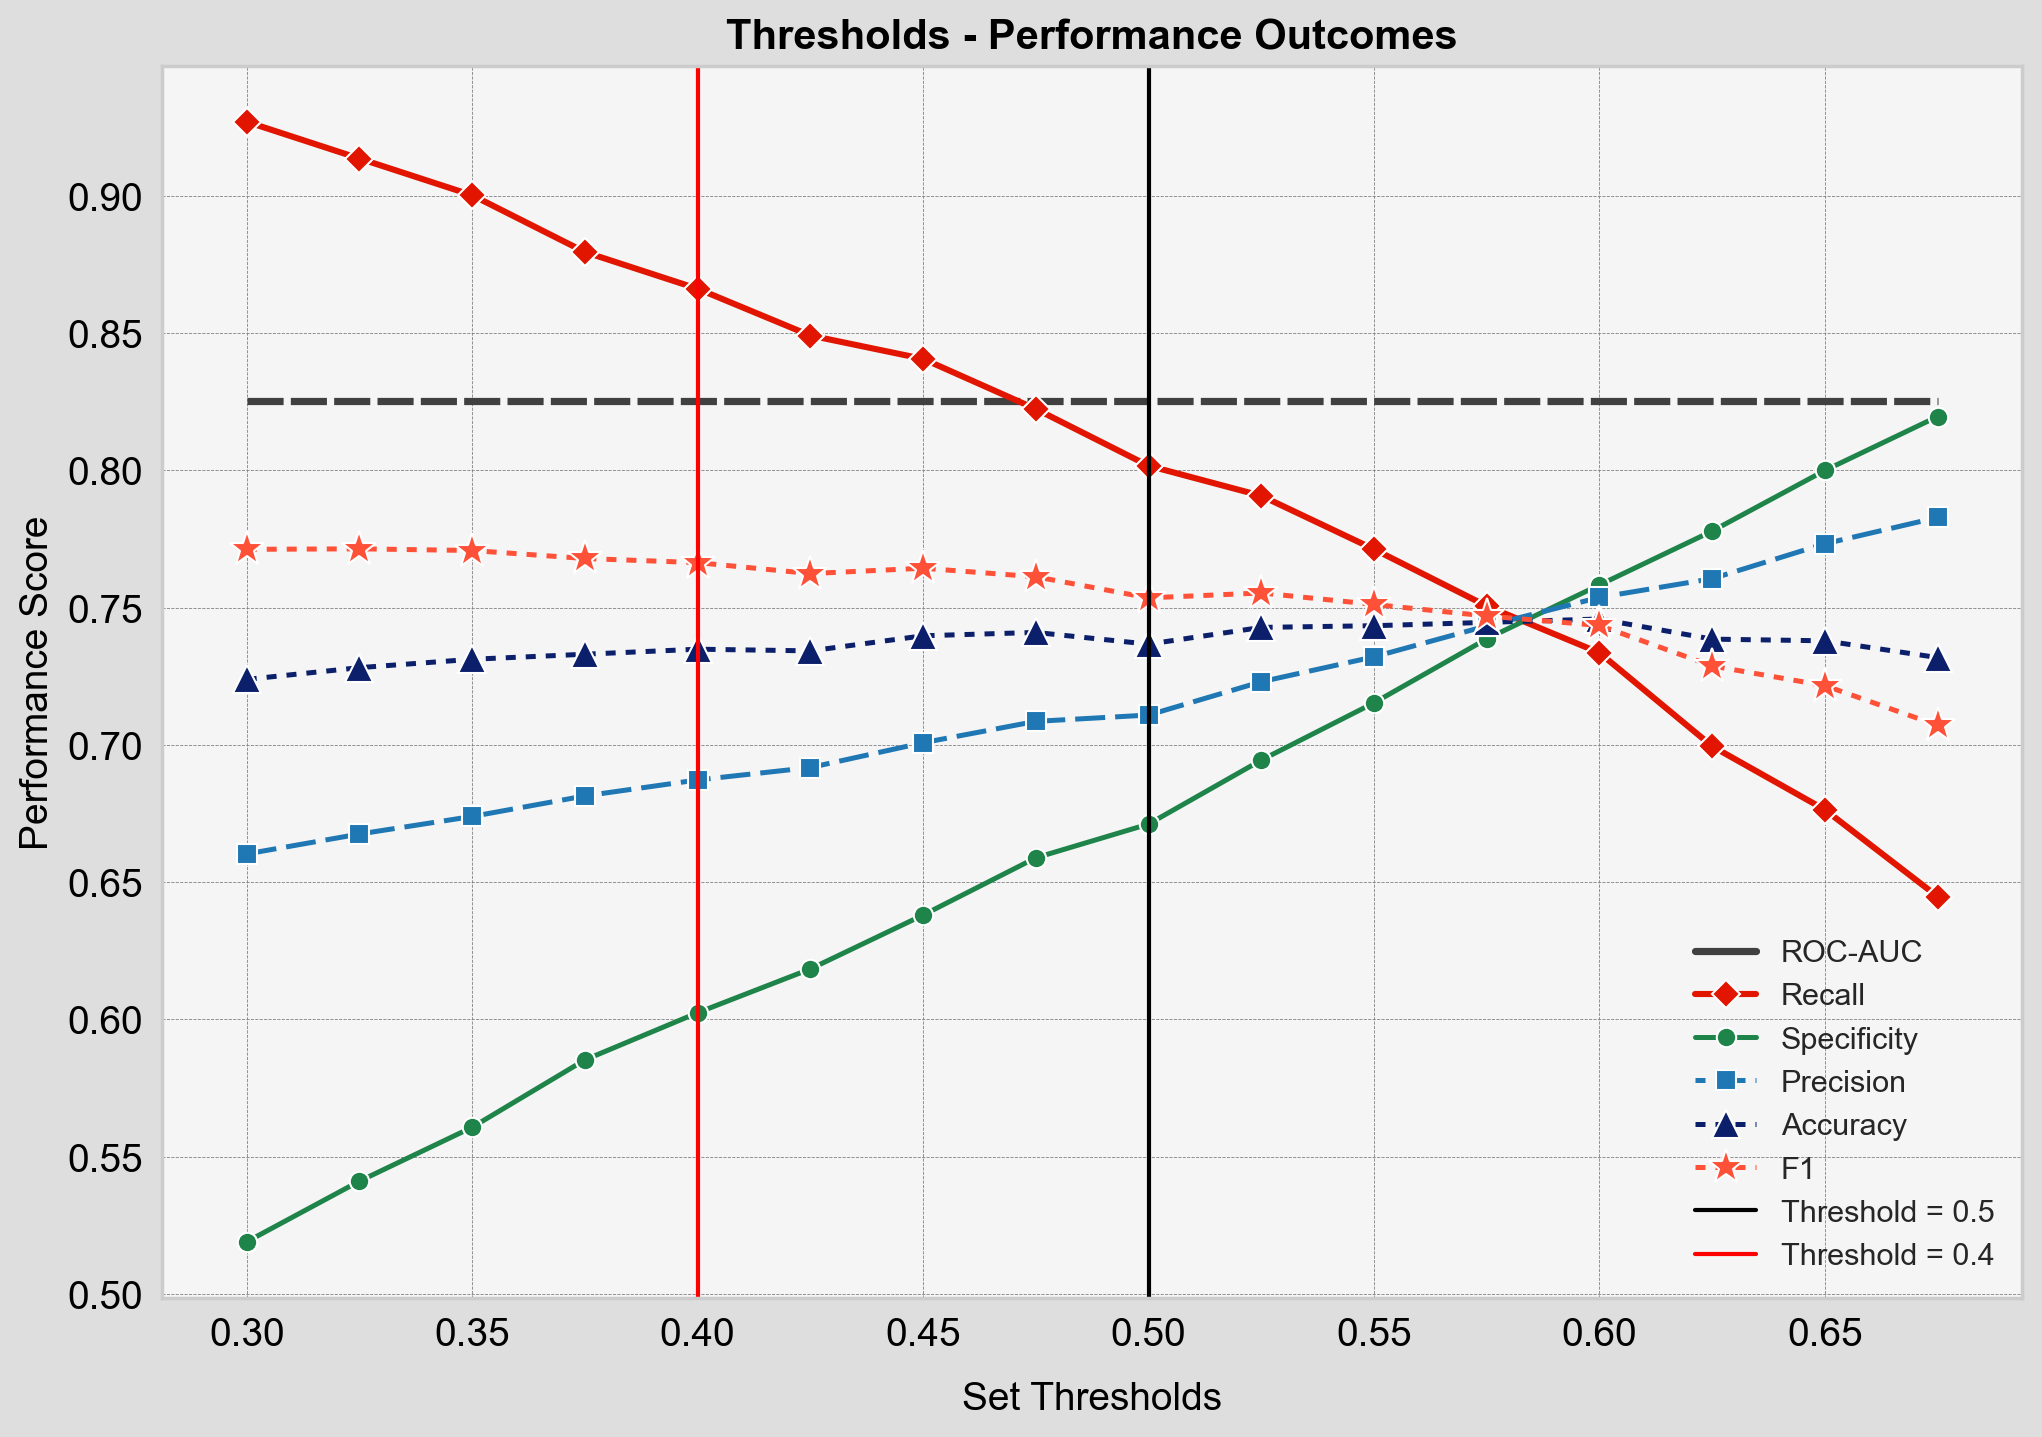

In [56]:
thresh_data = threshold_performance_df.copy()

# Setup plot. 
f, ax = plt.subplots(figsize=(12,8), dpi=100)
f.set_facecolor("#dedede")  # Overall Background - Dark gray/black  2b2b2b
ax.set_facecolor("#f5f5f5")  #hh Plot area darker  353535  
plt.grid(color="gray", linestyle="--", linewidth=0.3)  # Add grid for readability

## Plot Engine - using filtered data
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['ROC-AUC'], color='#404040',
             markersize=6, linewidth=2.6, label="ROC-AUC"
            )
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['Recall % Trues Ident.'], color='#e11500', 
             markersize=7, marker="D", linewidth=2.2, label="Recall"
            )
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['Specificity'], color='#1e8449', 
             markersize=7, marker="o", linewidth=1.8, label="Specificity"
            )
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['Precision % Pred.'], color='#1F77B4', 
             markersize=7, marker="s", dashes=(2,2), linewidth=1.8, label="Precision"
            )
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['Accuracy'], color='#0b1f6a', 
             markersize=10, marker="^", dashes=(2,2), linewidth=1.8, label="Accuracy"
            )
sns.lineplot(x=thresh_data['Threshold'], y=thresh_data['F1'], color='#ff5038', 
             markersize=13, marker="*", dashes=(2,2), linewidth=1.8, label="F1"
            )

plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1.5, label='Threshold = 0.5')
plt.axvline(x=0.4, color='red', linestyle='-', linewidth=1.5, label='Threshold = 0.4')

plt.title('Thresholds - Performance Outcomes', fontsize = 15, fontweight='bold', color='black')
plt.xlabel('Set Thresholds', fontsize=14, labelpad=10, color='black')
plt.ylabel('Performance Score', fontsize=14, color='black')
plt.legend(loc="lower right", fontsize=11)  # Display legend

### ticks
# ax.tick_params(axis='both', colors='white')  # Change tick marks to white
for label in ax.get_xticklabels():
    label.set_fontname('Arial')     
    label.set_fontsize(14)
    label.set_color('black')   
for label in ax.get_yticklabels():
    label.set_fontname('Arial')
    label.set_fontsize(14)
    label.set_color('black')

custom_dash = (5,1); custom_dash_2 = (8,1);  ##hh-because x dates are strings, apply dashes after.
custom_dash_3 = (4,2); custom_dash_4 = (4,3)  ##hh-because x dates are strings, apply dashes after.
custom_dash_5 = (3,3); custom_dash_6 = (6,2) 
ax.get_lines()[0].set_dashes(custom_dash); #ax.get_lines()[1].set_dashes(custom_dash_2)
#ax.get_lines()[2].set_dashes(custom_dash_3); 
ax.get_lines()[3].set_dashes(custom_dash_4)
ax.get_lines()[3].set_dashes(custom_dash_5); ax.get_lines()[3].set_dashes(custom_dash_6)
plt.savefig("vent_threshold_mods.png", format="png", dpi=300, bbox_inches="tight")  # Save the plot to a PNG file
plt.show()

<hr style="border:11px solid #0b1f6a">

### **Feature Importance Analysis**

In [51]:
### Review shape of Test Data:
X_test.shape

(1639, 246)

In [52]:
### Feature names to pair with SHAP Data
vent_feature_names = X_test.columns.tolist()
print(vent_feature_names[0:50])

['ICUSTAY_NUMBER', 'Age_Admission', '50804_Calculated Total CO2', '50818_pCO2', '50820_pH', '50821_pO2', '50868_Anion Gap', '50882_Bicarbonate', '50912_Creatinine', '50931_Glucose', '50960_Magnesium', '50971_Potassium', '50983_Sodium', '51006_Urea Nitrogen', '51222_Hemoglobin', '51249_MCHC', '51265_Platelet Count', '51275_PTT', '51277_RDW', '51301_White Blood Cells', '220045_Heart Rate', '220210_Respiratory Rate', '220277_O2 saturation pulseoxymetry', '220339_PEEP set', '223835_Inspired O2 Fraction', '223873_Paw High', '223876_Apnea Interval', '224168_Parameters Checked', '224641_Alarms On', '224687_Minute Volume', '224697_Mean Airway Pressure', '226253_SpO2 Desat Limit', '226512_Admission Weight (Kg)', 'LABEL_Non-invasive Ventilation', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'GENDER_M', 'Resp_Diag_Label_Resp_Related', '220048_Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2) ', '220048_Heart Rhythm_2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1) ', '220

In [53]:
### Create a SHAP explainer object w/ Probabilities
explainer_prob = shap.Explainer(xgb_mod_ventilation, X_train, model_output="probability")  # Ensure model output is probability (not log-odds)

### Explainer with Probabilities not Log Odds
shap_prob_values = explainer_prob.shap_values(X_test)

100%|===================| 1633/1639 [04:50<00:01]        

In [54]:
### Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_mod_ventilation)
shap_values = explainer.shap_values(X_test)

In [55]:
print(shap_values.shape)
print(shap_prob_values.shape)

(1639, 246)
(1639, 246)


In [56]:
shap_prob_values[0:2,0:7]

array([[-0.00312709,  0.01594015, -0.00438092,  0.03598138,  0.0254294 ,
         0.02548384, -0.0003405 ],
       [-0.00124095,  0.01122437,  0.00322614,  0.00345665,  0.00134944,
         0.06691652,  0.00396564]])

In [57]:
shap_values[0:2,0:7]

array([[-0.0246337 ,  0.12414581, -0.04489524,  0.1954794 ,  0.15182145,
         0.14616573, -0.01218209],
       [-0.00843653,  0.09238361,  0.01991167, -0.00333957,  0.01551116,
         0.37447545,  0.05051382]], dtype=float32)

#### **Base Value Review**

In [58]:
# # Optional: extract base value (expected model output)
# base_value = explainer.expected_value

In [59]:
# # Example: prediction for the first sample
# pred = xgb_mod_ventilation.predict_proba(X_test.iloc[[0]])[0, 1]
# shap_sum = shap_values[0].values.sum()
# base_plus_shap = base_value + shap_sum

# print(f"Model prediction:        {pred:.4f}")
# print(f"Base + SHAP sum:         {base_plus_shap:.4f}")
# print(f"SHAP additive difference: {shap_sum:.4f}")

In [60]:
# Select SHAP values for a specific class (e.g., class 0) for all samples
# shap_values_class0 = shap_values[:, :, 0] # Select all samples for class 0

#### **Plotting Results**

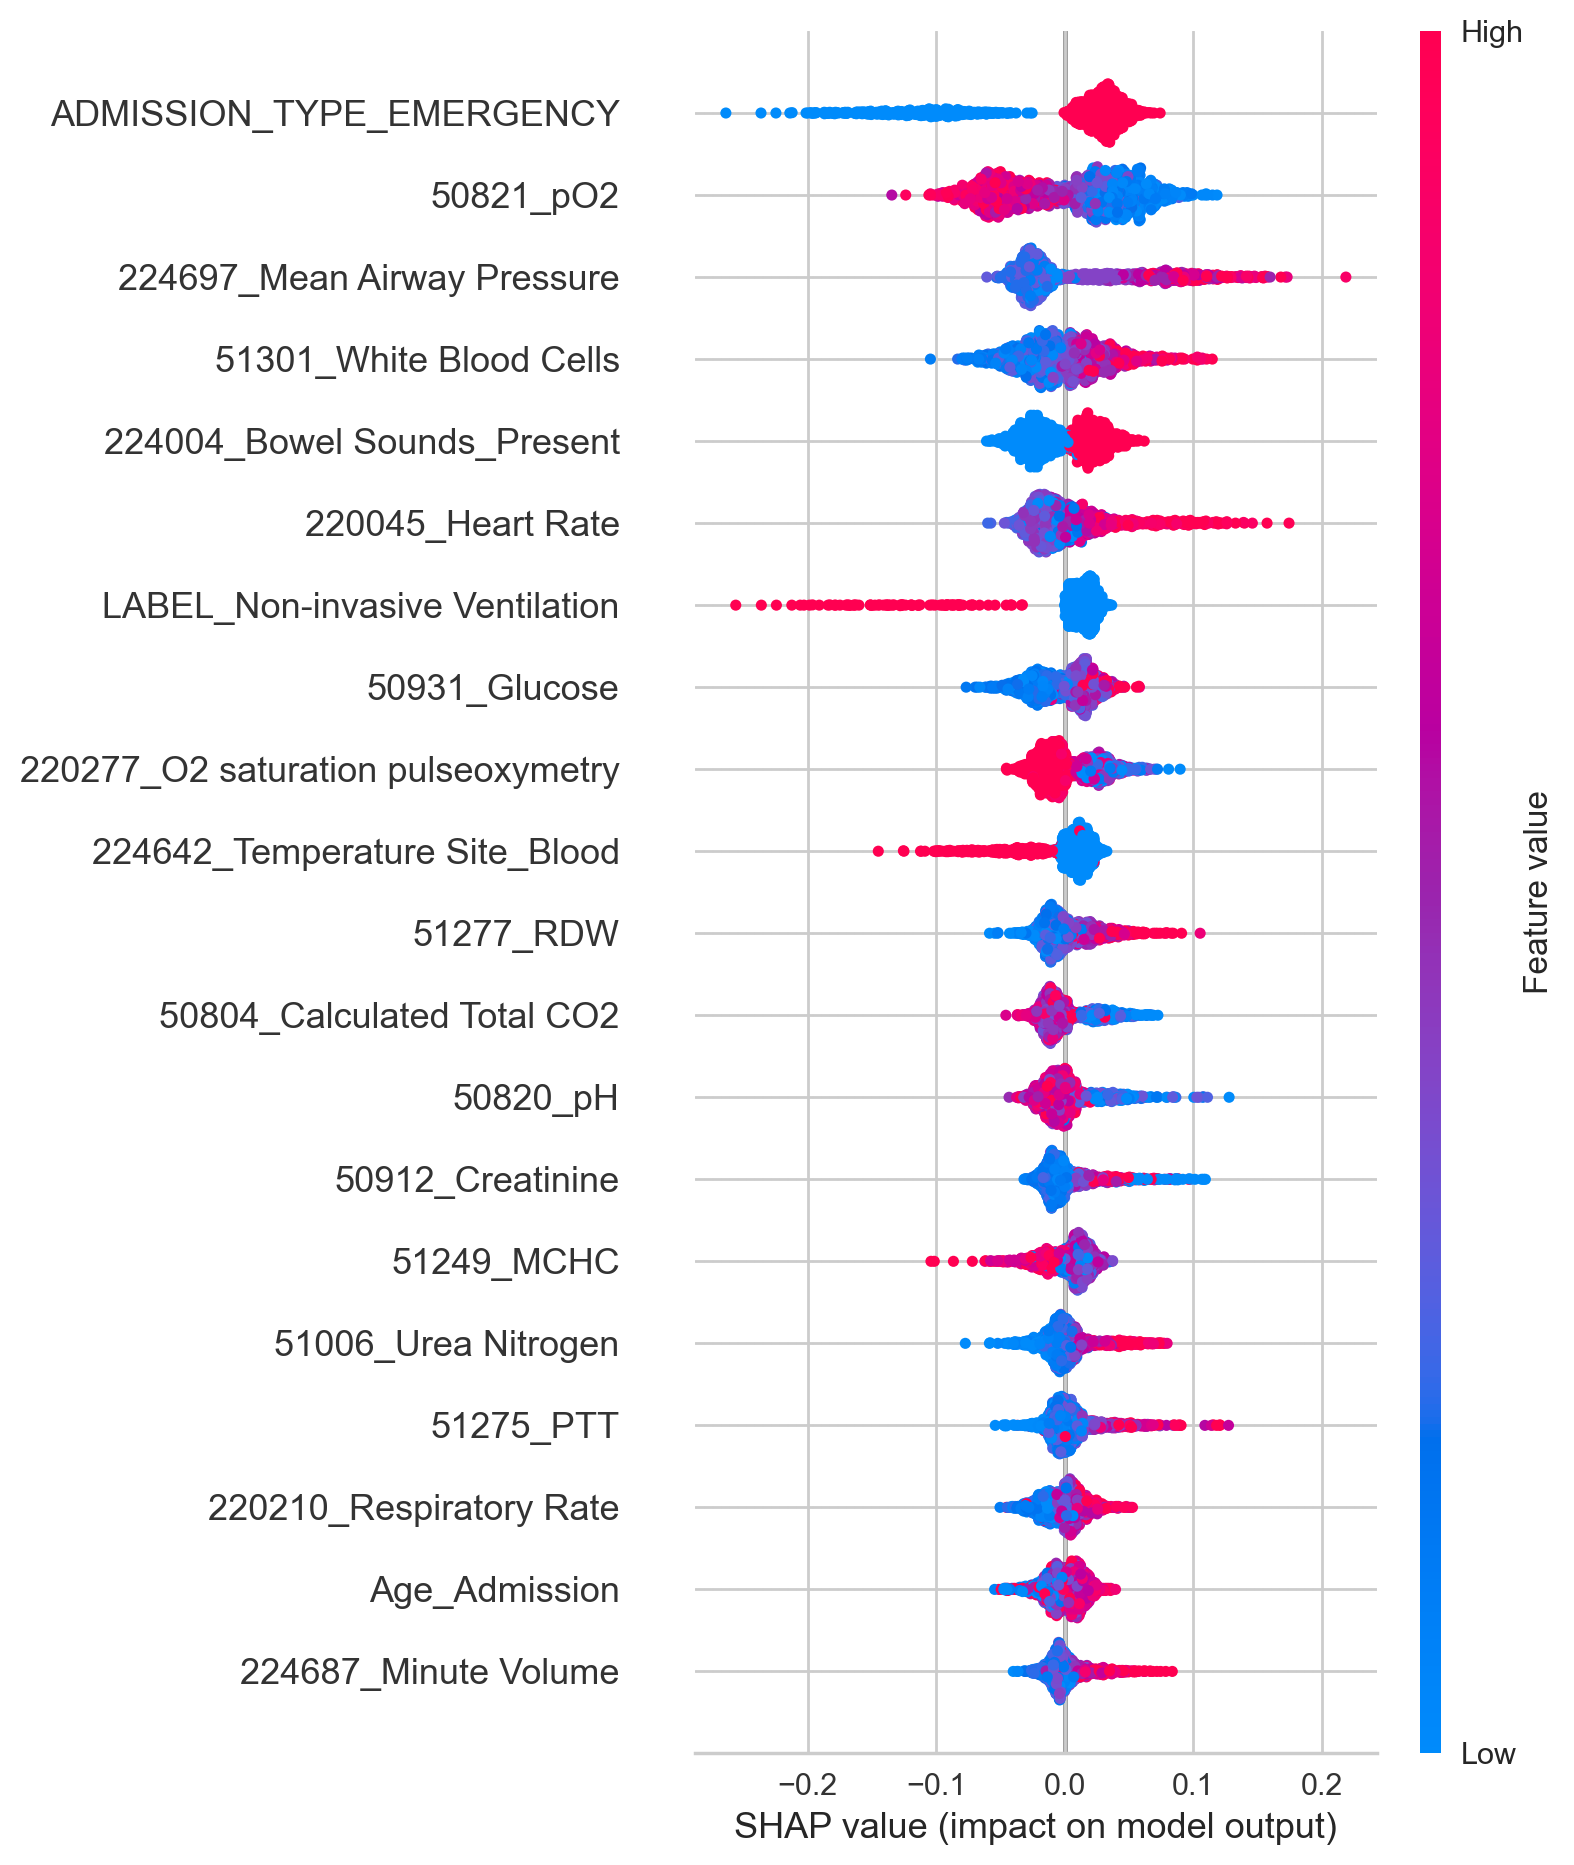

In [61]:
# Create summary plot without displaying it immediately
shap.summary_plot(shap_prob_values, X_test, feature_names=vent_feature_names, show=False)

# Save the active Matplotlib figure
plt.gcf().savefig("xgb_ventilation_shap_summary_plot.png", dpi=300, bbox_inches='tight')

# Optional: Close the plot
plt.show()
plt.close()


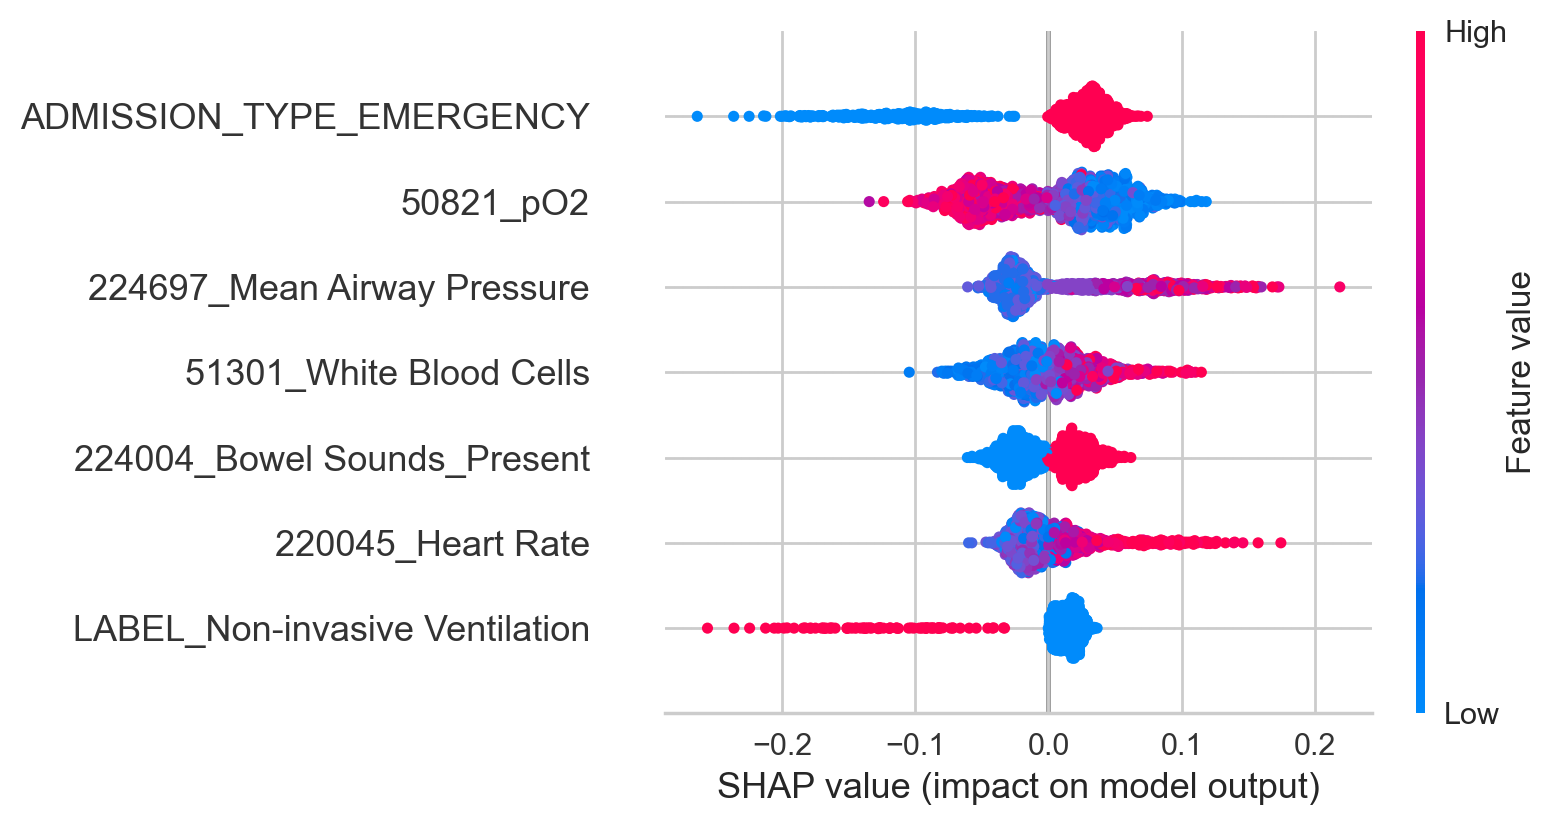

In [62]:
# Limit to top 20 features (adjust as needed)
shap.summary_plot(
    shap_prob_values,
    X_test,
    feature_names=vent_feature_names,
    show=False,
    max_display=7
)

# Save the active Matplotlib figure
plt.gcf().savefig("xgb_ventilation_shap_summary_plot_xx.png", dpi=300, bbox_inches='tight')

# Close the plot
plt.show()
plt.close()

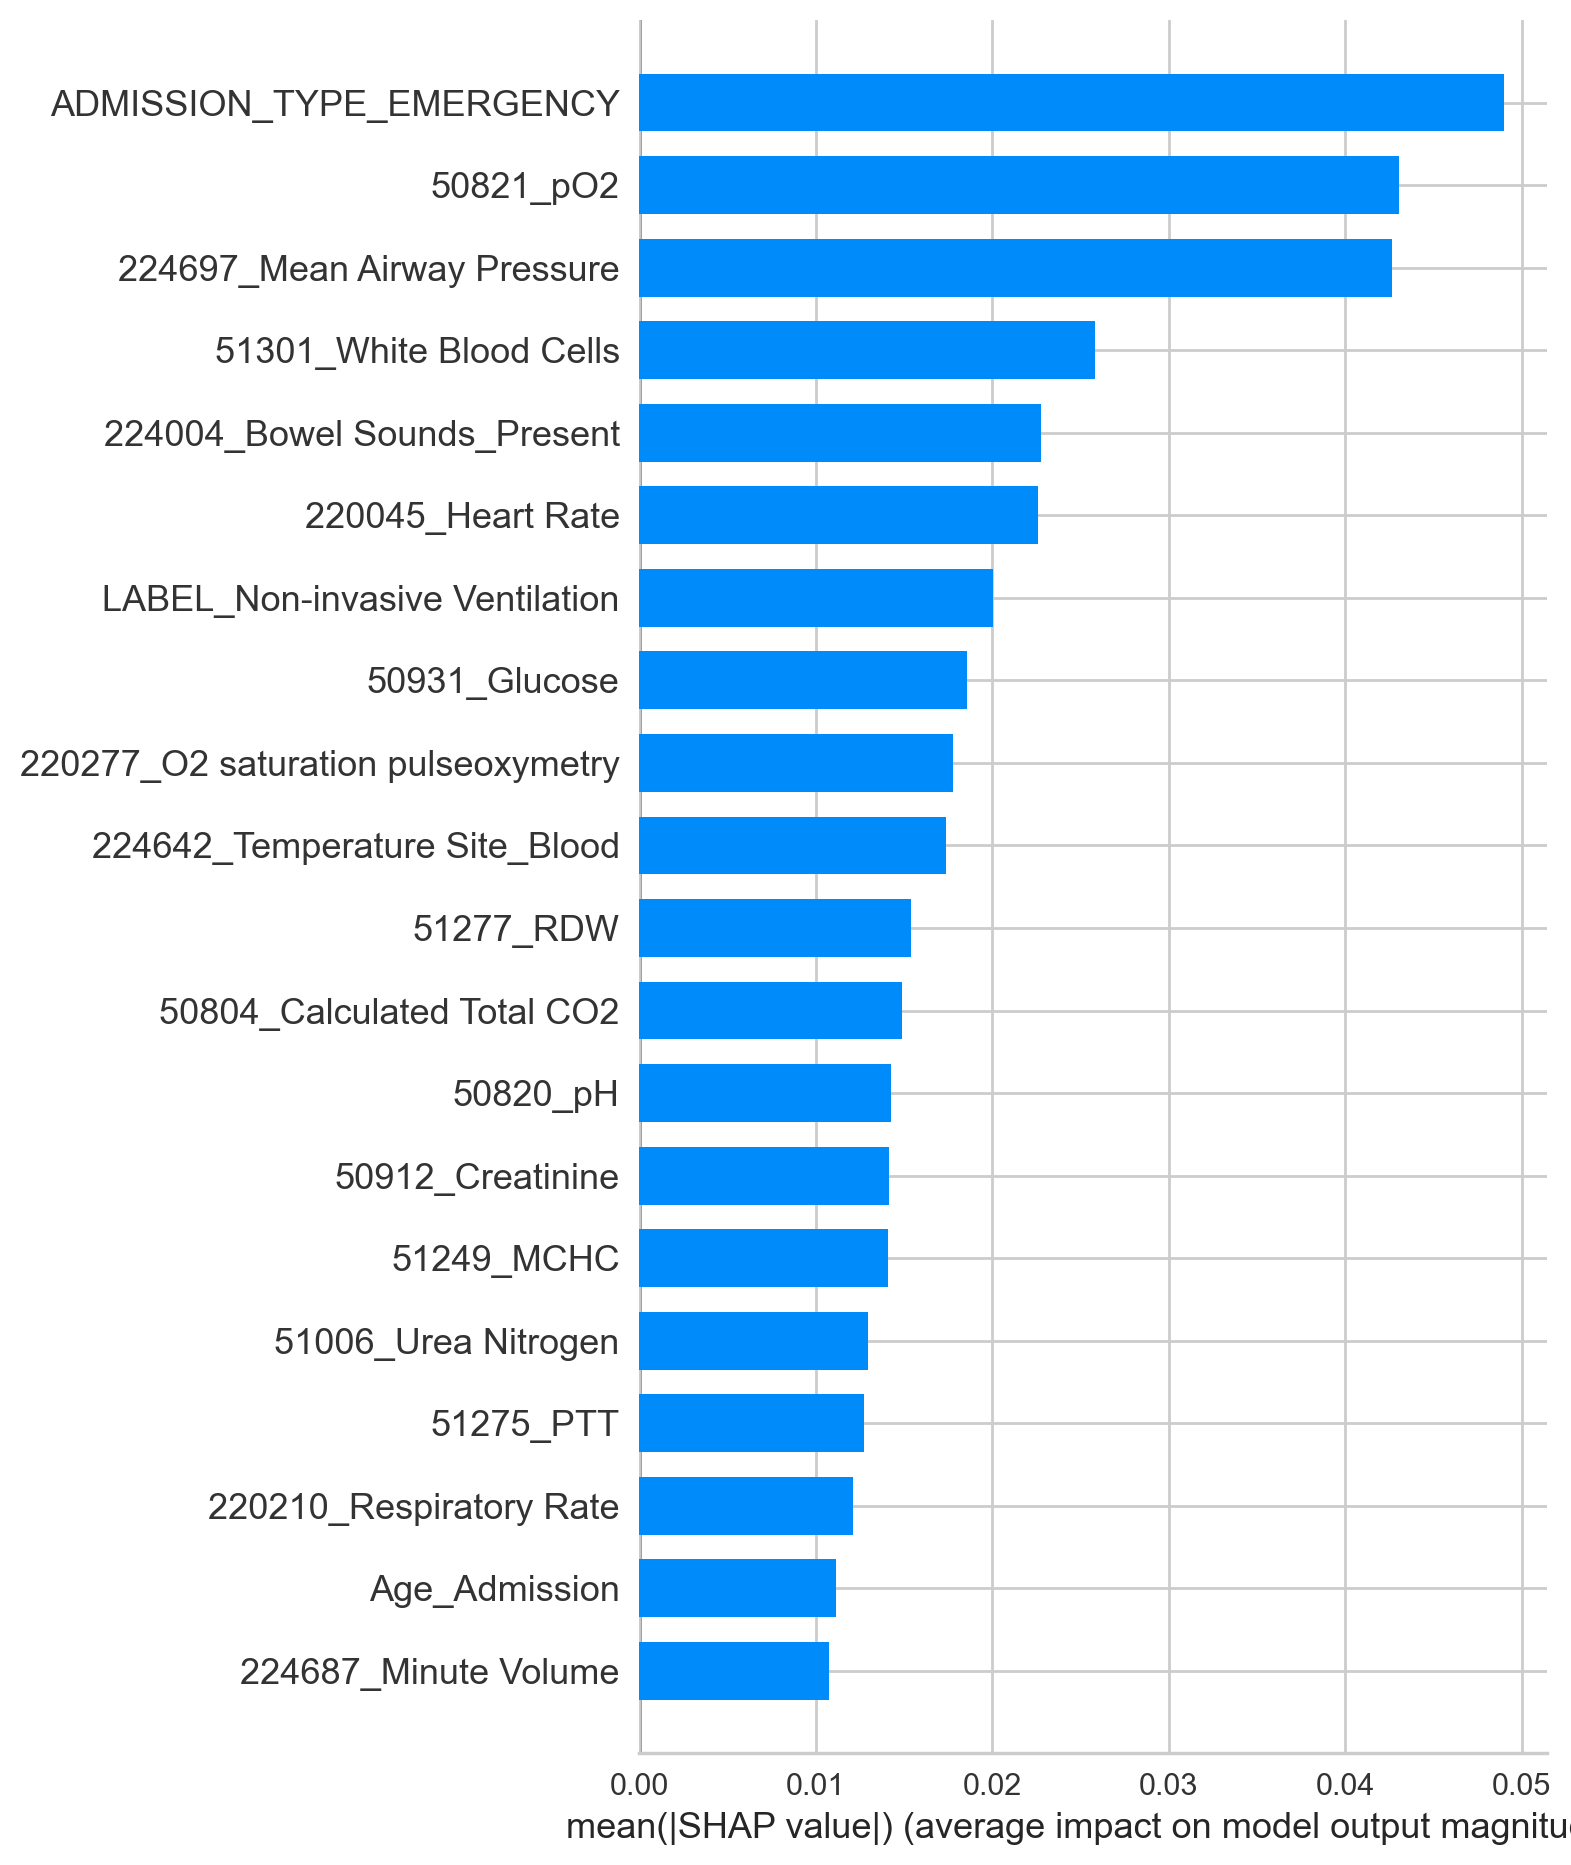

In [63]:
shap.summary_plot(shap_prob_values, X_test, feature_names=vent_feature_names, plot_type="bar")

#### **Create Own Data Frame**

In [64]:
print(vent_feature_names[0:20])

['ICUSTAY_NUMBER', 'Age_Admission', '50804_Calculated Total CO2', '50818_pCO2', '50820_pH', '50821_pO2', '50868_Anion Gap', '50882_Bicarbonate', '50912_Creatinine', '50931_Glucose', '50960_Magnesium', '50971_Potassium', '50983_Sodium', '51006_Urea Nitrogen', '51222_Hemoglobin', '51249_MCHC', '51265_Platelet Count', '51275_PTT', '51277_RDW', '51301_White Blood Cells']


In [65]:
vent_feature_shap_data = pd.DataFrame(shap_prob_values, columns=vent_feature_names).reset_index()
vent_feature_shap_data = vent_feature_shap_data.T.reset_index()
vent_feature_shap_data.rename(columns={vent_feature_shap_data.columns[0]: 'Feature'}, inplace=True)
vent_feature_shap_data = vent_feature_shap_data.iloc[1:,:]

In [66]:
vent_feature_shap_data.head(2)

,Feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1

In [67]:
vent_feature_shap_data.dtypes

Feature     object
0          float64
1          float64
2          float64
3          float64
            ...   
1634       float64
1635       float64
1636       float64
1637       float64
1638       float64
Length: 1640, dtype: object

In [68]:
### Calc. the Absolute Sum of Values for each Feature
vent_feature_shap_data['SHAP_Abs_Mean'] = vent_feature_shap_data.iloc[:, 1:].abs().mean(axis=1)

In [69]:
vent_feature_shap_mean_df = vent_feature_shap_data[['Feature','SHAP_Abs_Mean']]
print(vent_feature_shap_mean_df.shape)
vent_feature_shap_mean_df = vent_feature_shap_mean_df.sort_values(['SHAP_Abs_Mean'], ascending=False)
vent_feature_shap_mean_df.head(10)

(246, 2)


,Feature,SHAP_Abs_Mean
35,ADMISSION_TYPE_EMERGENCY,0.048996
6,50821_pO2,0.043035
31,224697_Mean Airway Pressure,0.042636
20,51301_White Blood Cells,0.025837
173,224004_Bowel Sounds_Present,0.022747
21,220045_Heart Rate,0.022595
34,LABEL_Non-invasive Ventilation,0.020038
10,50931_Glucose,0.018580
23,220277_O2 saturation pulseoxymetry,0.017758
240,224642_Temperature Site_Blood,0.017353


#### **Save**

In [70]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'xgb_feature_shap_abs_values'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
# vent_id_procedures_subjects.to_csv(csv_naming, index=False, compression='gzip')
vent_feature_shap_mean_df.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to xgb_feature_shap_abs_values.csv


In [71]:
### Record Count
vent_feature_shap_mean_df.query('SHAP_Abs_Mean > .007').shape

(32, 2)

#### **Plot**

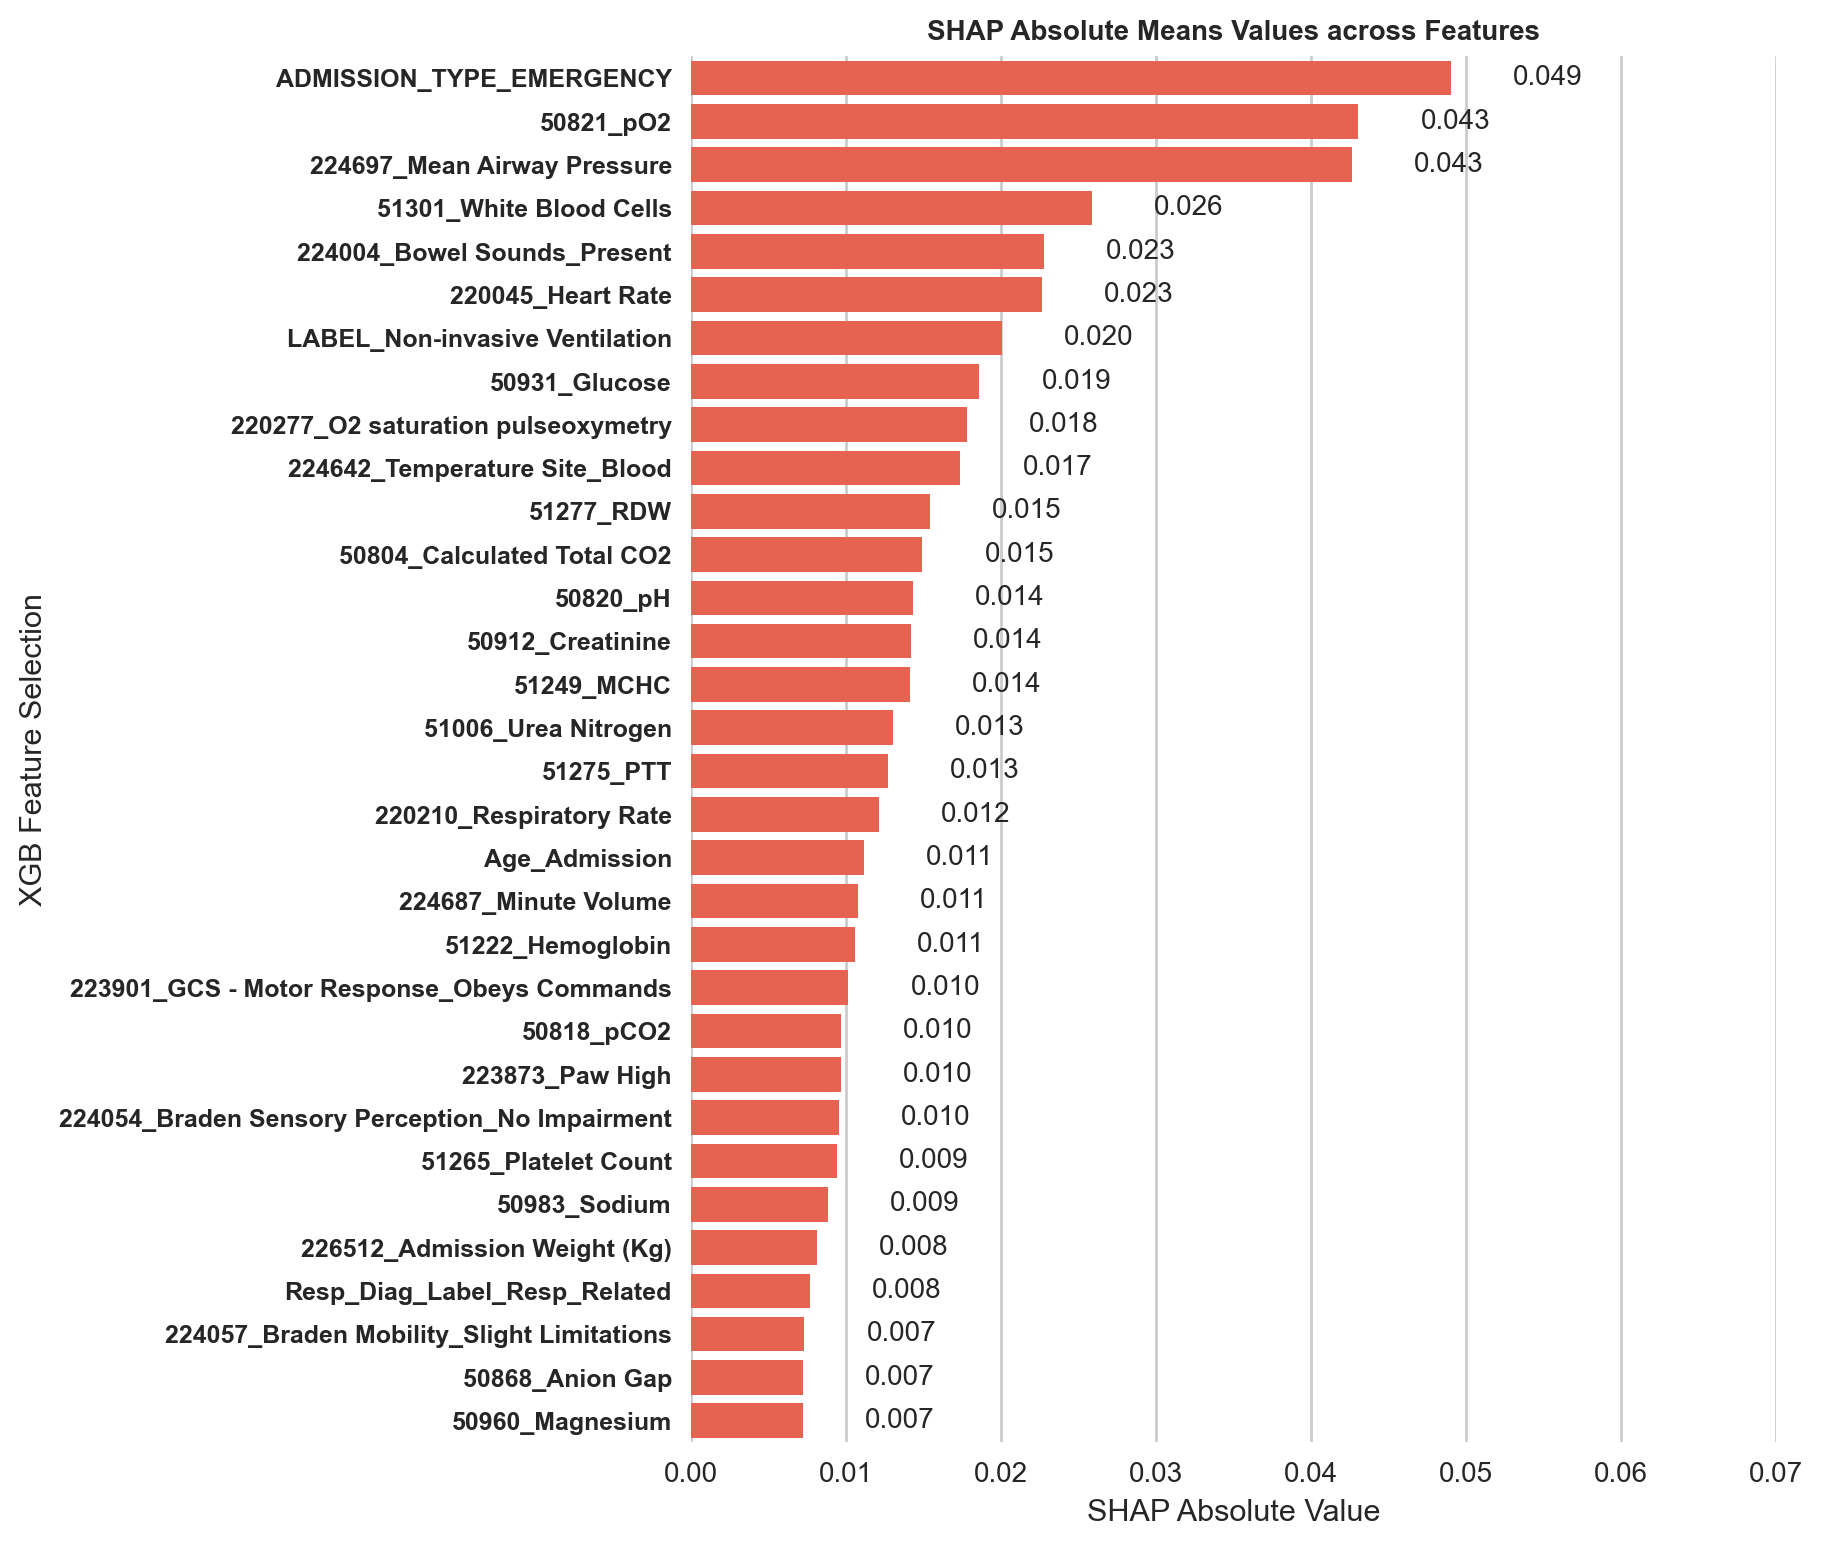

In [72]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 9), dpi=100)

# Plot the Feature Count 
sns.set_color_codes("pastel")
sns.barplot(x="SHAP_Abs_Mean", y="Feature", data=vent_feature_shap_mean_df.query('SHAP_Abs_Mean > .007'),
            label="Number of Rows / Labels by Category", color="#ff5038")  #  ff5038 1F77B4

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + .004,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.3f}'.format(width), # set variable to display, 2 decimals, is the second value 1.decimals
            ha = 'left',   # horizontal alignment
            va = 'center',   # vertical alignment
            fontsize=10, )      

### Information
ax.set_title('SHAP Absolute Means Values across Features', fontsize=10, fontweight='bold')
# ax.legend(ncol=2, loc="lower center", frameon=True)
ax.set(xlim=(0, .07), ylabel="XGB Feature Selection", xlabel="SHAP Absolute Value")
ax.tick_params(axis='y', labelsize=10)  # asdfsda
labels = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(labels, fontweight='bold', fontsize=9)
sns.despine(left=True, bottom=True)
plt.savefig("bar_xgb_shap_features_sorted.png", format="png", dpi=300, bbox_inches="tight")  # Save the plot to a PNG file
plt.show()  # Show the plot (optional)

----
## **Model Feature Selection and Performance**

In [73]:
vent_feature_shap_mean_df.head(5)

,Feature,SHAP_Abs_Mean
35,ADMISSION_TYPE_EMERGENCY,0.048996
6,50821_pO2,0.043035
31,224697_Mean Airway Pressure,0.042636
20,51301_White Blood Cells,0.025837
173,224004_Bowel Sounds_Present,0.022747


In [74]:
### Listing of Ranked Features to select from
ranked_features = vent_feature_shap_mean_df['Feature'].tolist()
ranked_features[0:5]

['ADMISSION_TYPE_EMERGENCY',
 '50821_pO2',
 '224697_Mean Airway Pressure',
 '51301_White Blood Cells',
 '224004_Bowel Sounds_Present']

In [75]:
feature_set_sizes = list(range(5, len(ranked_features)+1, 5))  # e.g. 5, 10, 15, ...
feature_set_sizes = feature_set_sizes[0:50]
print(feature_set_sizes)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245]


In [76]:
# Store evaluation results
results = []

for k in feature_set_sizes:
    selected_features = ranked_features[:k]
    X_subset = X_train[selected_features]
    
    xgb_feat_select_mod = XGBClassifier(
        n_estimators = 800,
        max_depth = 16,
        learning_rate=0.1,
        eval_metric='auc',
        gamma = 0,
        reg_alpha = .5,
        random_state=42
    )
    
    # Evaluate using cross-validated metrics
    scores = cross_validate(
        xgb_feat_select_mod,
        X_subset,
        y_train,
        cv=5,
        scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1'],
        return_train_score=False,
        n_jobs=-1
    )
    
    results.append({
        'num_features': k,
        'mean_auc': scores['test_roc_auc'].mean(),
        'mean_accuracy': scores['test_accuracy'].mean(),
        'mean_recall': scores['test_recall'].mean(),
        'mean_precision': scores['test_precision'].mean(),
        'mean_f1': scores['test_f1'].mean(),
        'features_used': selected_features
    })

# Convert to DataFrame
xgb_feat_select_results = pd.DataFrame(results)

In [77]:
xgb_feat_select_results = xgb_feat_select_results.sort_values('mean_auc', ascending=False)
xgb_feat_select_results.head(15)

,num_features,mean_auc,mean_accuracy,mean_recall,mean_precision,mean_f1,features_used
25,130,0.808665,0.734170,0.783985,0.715084,0.747903,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
20,105,0.808482,0.736306,0.782167,0.718587,0.748957,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
12,65,0.808371,0.736459,0.787624,0.716560,0.750365,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
29,150,0.808306,0.734171,0.785501,0.714490,0.748260,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
14,75,0.808286,0.738291,0.786110,0.719600,0.751341,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
28,145,0.808172,0.734781,0.787020,0.714665,0.749046,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
22,115,0.807699,0.734322,0.781258,0.716434,0.747361,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
33,170,0.807673,0.733407,0.786108,0.713272,0.747852,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
30,155,0.807673,0.733407,0.786108,0.713272,0.747852,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."
31,160,0.807673,0.733407,0.786108,0.713272,0.747852,"[ADMISSION_TYPE_EMERGENCY, 50821_pO2, 224697_M..."


In [78]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'xgb_feat_selection_model_peform'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
xgb_feat_select_results.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to xgb_feat_selection_model_peform.csv


------
### **Execute Model with Isolated Features**
- ajkdslfjlskdaf

In [ ]:
### Copy the X Values
X_val_feat_select = X_val.copy()

In [ ]:
## Test / Train Split
X_train_feat_selec, X_test_feat_selec, y_train, y_test = train_test_split(X_val_feat_select, y_val, test_size=0.20, stratify=y_val, random_state=55)

In [ ]:
### Modify to only take the selected number of features
feature_count_k = 60
select_feat = ranked_features[:feature_count_k]
X_train_feat_selec = X_train_feat_selec[select_feat]
X_test_feat_selec = X_test_feat_selec[select_feat]

In [ ]:
classes = np.sort(y_train.unique())  #
classes

In [ ]:
### Model 
n = 800
depth = 16
lr = .01
# spw = 5
gam = 0
reg_alpha = 1

xgb_mod_vent_feat = XGBClassifier(
        # objective='binary:logistic',
        n_estimators=n,
        max_depth=depth,
        learning_rate=lr,
        # scale_pos_weight=spw,
        gamma=gam,
        reg_alpha=reg_alpha,     # L1 regularization term
        eval_metric='auc',
        random_state=37,
        n_jobs=-1
    )

xgb_mod_vent_feat.fit(X_train, y_train)
y_pred = xgb_mod_vent_feat.predict(X_test)
y_proba = xgb_mod_vent_feat.predict_proba(X_test)[:, 1]

In [ ]:
# Generate confusion matrix
labels_rev = xgb_mod_ventilation.classes_[::-1]   ### Reverse Labels
cm_xgb = confusion_matrix(y_test, y_pred, labels=labels_rev) 

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels = ['Sig_Over_Day [1]', 'Mod_Under_Day [0]'])
TP, FN, FP, TN = cm_xgb.ravel()

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Oranges, ax=ax, colorbar=True)  ##coolwarm bwr seismic PiYG RdYlBu Reds Spectral
ax.grid(False)           # <- kill the grid
for spine in ax.spines.values():
    spine.set_visible(False)   # optional: hide the outer box
plt.title('Ventilation Classification Confusion Matrix')
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') # Save to file (adjust path/format as needed)
plt.show()

In [ ]:
TP, FN, FP, TN = cm_xgb.ravel()
print(TP, FN, FP, TN)
633 +155+ 225+ 547

In [ ]:
## Print classification metrics:
classif_metrics(cm_xgb, y_test, y_pred, y_proba)

In [ ]:
visualizer = ROCAUC(xgb_mod_ventilation, classes=classes)

# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()         

--------
Scratch

### **Feature Importance Analysis**

In [ ]:
# thresholds = np.sort(xgb_mod.feature_importances_)
thresholds = np.sort(thresholds)[::-1]
sorted_indices = np.argsort(thresholds)[::-1]

In [ ]:
thresholds[0:30]

In [ ]:
sorted_indices

In [ ]:
data_capture = []
for thresh in thresholds:
 
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_scaled)
    # train model
    selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test_scaled)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

-----
### Checking the Confusion Matrix due to Reversal Above

In [ ]:
labels 

In [ ]:
# Generate confusion matrix without reversing labels
labels = xgb_mod_ventilation.classes_   # No reversal
cm_xgb_norm = confusion_matrix(y_test, y_pred, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb_norm,
    display_labels=['Mod_Under_Day [0]', 'Sig_Over_Day [1]']  # Match order of labels
)

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
ax.grid(False)  # Remove grid
for spine in ax.spines.values():
    spine.set_visible(False)  # Optional: hide outer box
plt.title('Confusion Matrix')
plt.show()